# Hesitation analysis nb
Nb for testing out somr functions and other stuff for hesitation analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pythonlib.tools.stroketools import *
from drawmonkey.tools.utils import *
from drawmonkey.tools.preprocess import *
from pyvm.classes.videoclass import Videos
from pythonlib.tools.expttools import load_yaml_config
from pyvm.globals import BASEDIR
from drawmonkey.tools.handtrack import HandTrack, getTrialsCameraFrametimes
from pyvm.utils.directories import get_metadata
import matplotlib.pyplot as plt
from pythonlib.drawmodel.strokePlots import *
import pythonlib
import pickle
from pythonlib.tools.camtools import *


In [15]:
#Add data here as needed
decide_data_dict = {
    'diego1': ('Diego','230913_dirgrammardiego5d'),
    'diego2': ('Diego','231118_gramdiego1b'),
    'diego3': ('Diego','230726_dirgrammardiego2'),
    'pancho1': ('Pancho','231114_grampancho1'),
    'pancho2': ('Pancho','231116_grampancho1')
}

#Change key here ot chaneg what data being used in the plotting
key_to_use = 'pancho2'

animal = decide_data_dict[key_to_use][0]
name = decide_data_dict[key_to_use][1]
#Only work if 1 session
date = name.split('_')[0]
expt = name.split('_')[1]

### Load presaved data (old)

In [10]:
dat_dir = f'/home/danhan/freiwaldDrive/dhanuska/hand_track/{animal}/{name}/processed_data.pkl'
with open(dat_dir,'rb') as f:
    dat_load = pickle.load(f)
#Only work if one session
fd = loadSingleDataQuick(animal,date,expt,1)

-- loaded presaved data: /home/danhan/freiwaldDrive/kgupta/macaque_data/Pancho/231116/231116_101721_grampancho1_Pancho_1.pkl


In [11]:
dat_trials = dat_load['220914_f12_dlc']
# dat_trials = dat_load['220914_flea_bfs1_dlc']

In [12]:
#Check skipped reaosns rq to make sure data looks fine
#Should mainly just be bc no beh'
print(set(d['skipped'] for d in dat_trials.values()))
print(len(dat_trials))

{None, 'no_beh_data_found'}
893


In [ ]:
#Make sure we have the  right keys for this df (mainly likelihood_min and strokes_cam_calc_onoff )
trial_check = 72
if 'strokes_cam_calc_onoff' in dat_trials[trial_check].keys() \
    and 'likelihood_min' in dat_trials[trial_check].keys():
    
    print('keys look good')
else:
    print('keys look bad, maybe old data extraction or empty trial')
    print(dat_trials[trial_check].keys())


keys look bad, maybe old data extraction or empty trial
dict_keys(['strokes_cam', 'gaps_cam', 'pts_time_cam_all', 'strokes_touch', 'strokes_task', 'pnut_strokes', 'strokes_raw_times', 'reg_strokes_cam', 'reg_gaps_cam', 'reg_pts_time_cam_all', 'trans_strokes_cam', 'trans_gaps_cam', 'trans_pts_time_cam_all', 'skipped'])


### Use preprocess_clean func to laod data on the fly

In [173]:
from drawmonkey.tools.ht_preprocess import preprocess_clean
from pythonlib.tools.stroketools import strokesInterpolate2

trange = range (200,220)
dat_func = preprocess_clean(name,animal,True,trange=trange)
# dat_func = preprocess_clean(name,animal,True)
#Get upsampled shit
for coefs, d_coef in dat_func.items():
    for trial,d_trial in d_coef.items():
        if d_trial['skipped'] is None:
            cam_fs = 1/np.mean(np.diff(d_trial['trans_pts_time_cam_all']))
            dat_func[coefs][trial]['trans_pts_time_cam_all_int'] = strokesInterpolate2([d_trial['trans_pts_time_cam_all']],kind='linear',N=["fsnew",1000,cam_fs])[0]



Vid range(200, 220)
-- loaded presaved data: /home/danhan/freiwaldDrive/kgupta/macaque_data/Pancho/231116/231116_101721_grampancho1_Pancho_1.pkl
No campy data found for trial_ml2 =  1
Not doing regression because reg file already exists, delete if you want to rerun the regression. Running step 4 again automatically removes it.
Not doing regression because reg file already exists, delete if you want to rerun the regression. Running step 4 again automatically removes it.
No touch screen data found here
No touch screen data found here
No touch screen data found here
No touch screen data found here
No touch screen data found here
No touch screen data found here
No touch screen data found here
No touch screen data found here
No touch screen data found here
No touch screen data found here
No touch screen data found here
No touch screen data found here
No touch screen data found here
No touch screen data found here
Searching using this string:
/home/danhan/freiwaldDrive/dhanuska/hand_track/Pa

In [174]:
from drawmonkey.tools.ht_preprocess import preprocess_merge
ht_dat = preprocess_merge(dat_func,'220914_f12_dlc')

In [241]:
ht_dat[210].keys()

dict_keys(['strokes_cam', 'gaps_cam', 'pts_time_cam_all', 'strokes_touch', 'strokes_task', 'pnut_strokes', 'strokes_raw_times', 'likelihood_min', 'reg_strokes_cam', 'reg_gaps_cam', 'reg_pts_time_cam_all', 'trans_strokes_cam', 'trans_gaps_cam', 'trans_pts_time_cam_all', 'onset_offset_times', 'strokes_cam_calc_onoff', 'gaps_cam_calc_onoff', 'skipped', 'trans_pts_time_cam_all_int', 'coefs_used'])

In [70]:
#Load in dataset
from pythonlib.dataset.dataset import load_dataset_notdaily_helper, load_dataset_daily_helper
from pythonlib.dataset.dataset_strokes import preprocess_dataset_to_datstrokes
from pythonlib.drawmodel.analysis import *
import seaborn as sns

D = load_dataset_daily_helper(animal, date)
D.trialcode_tuple_extract_assign()





Searching using this string:
/home/danhan/code/drawmonkey/drawmonkey/expt_metadat/*231116-*Pancho.**
Found this many paths:
0
Searching using this string:
/home/danhan/code/drawmonkey/drawmonkey/expt_metadat_daily/*231116-*Pancho.**
Found this many paths:
1
---
/home/danhan/code/drawmonkey/drawmonkey/expt_metadat_daily/grampancho1-231116-Pancho.yaml
Loading this dataset Pancho grampancho1 231116
Searching using this string:
/home/danhan/freiwaldDrive/kgupta/analyses/database/*Pancho-*grampancho1-*231116-*/*dat*.pkl
-- Splitting off dir from fname
Found this many paths:
0
Searching using this string:
/home/danhan/freiwaldDrive/kgupta/analyses/database/BEH/*Pancho-*grampancho1-*231116-*/*dat*.pkl
-- Splitting off dir from fname
Found this many paths:
1
---
/home/danhan/freiwaldDrive/kgupta/analyses/database/BEH/Pancho-grampancho1-231116-231117_001511
----------------
Currently loading dataset pkl: /home/danhan/freiwaldDrive/kgupta/analyses/database/BEH/Pancho-grampancho1-231116-231117_00

/home/danhan/code/pythonlib/pythonlib/tools/pandastools.py:2594: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'IGN' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[column].isna(), column] = replace_with
/home/danhan/code/pythonlib/pythonlib/tools/pandastools.py:2594: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'IGN' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[column].isna(), column] = replace_with


Basis set of strokes: ['Lcentered-4-2-0', 'Lcentered-4-3-0', 'Lcentered-4-4-0', 'V-2-1-0', 'V-2-2-0', 'V-2-4-0', 'arcdeep-4-1-0', 'arcdeep-4-2-0', 'arcdeep-4-4-0', 'circle-6-1-0', 'line-8-1-0', 'line-8-2-0', 'line-8-3-0', 'line-8-4-0', 'squiggle3-3-1-0', 'squiggle3-3-2-0', 'squiggle3-3-2-1']
Deleting these columns with seqc in name: []
Appended columns gridsize!
SAVING at:  /home/danhan/freiwaldDrive/dhanuska/analyses/main/preprocess_general/Pancho_231116_grampancho1
0
100
200
300
400
500
600
700
This many strokes extracted:  2757
DONE!
Appended epoch to self.Dat
Appended character to self.Dat


/home/danhan/code/pythonlib/pythonlib/tools/pandastools.py:2594: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'IGN' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[column].isna(), column] = replace_with
/home/danhan/code/pythonlib/pythonlib/tools/pandastools.py:2594: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'IGN' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[column].isna(), column] = replace_with


In [238]:
D.Dat = mergeHTWithDataset(ht_dat,D)

In [239]:
D.Dat

,trial_end_method,online_abort,origin,donepos,motortiming,motorevents,holdtime,delaytime,pnut_ext,datetime,abort_params,ErrorCode,IsAbort,animal,beh_multiplier,bias_multiplier,binary_evaluation,block,circleness_obj,circleness_obj_rescaled,date,dist_total,dist_total_rescaled,frac_overlap,frac_overlap_rescaled,frac_strokes,frac_strokes_rescaled,frac_touched,frac_touched_rescaled,ft_decim,ft_decim_rescaled,ft_minobj,ft_minobj_offline,ft_minobj_offline_rescaled,ft_minobj_rescaled,hausdorff,hausdorff_rescaled,keepforsummary,numstrokes_frac,numstrokes_frac_rescaled,numstrokesorig,numstrokesorig_rescaled,pacman,pacman_rescaled,random_task,rew_total,score_final,seq_binary,seq_binary_rescaled,session,shortness,shortness_rescaled,traintest,trial,trialcode,which_metadat_idx,strokes_beh,expt,tvalfake,tvalday,aborted,insummarydates,date_sess,Task,unique_task_name,character,strokes_task,task_kind,plan_time,BehClass,epoch_rule_tasksequencer,INSTRUCTION_COLOR,epoch_color,epoch,supervision_online,superv_SEQUENCE_SUP,superv_SEQUENCE_ALPHA,superv_COLOR_ON,superv_COLOR_ITEMS_FADE_TO_DEFAULT_BINSTR,superv_COLOR_METHOD,superv_GUIDEDYN_ON,superv_VISUALFB_METH,supervision_stage_new,supervision_stage_concise,supervision_stage_semantic,epoch_superv,epoch_orig,superv_is_seq_sup,probe,monkey_train_or_test,los_info,los_set,date_MMDD,date_epoch,task_stagecategory,taskgroup,FEAT_num_strokes_task,Tkbeh_stkbeh,Tkbeh_stktask,Tktask,shape_is_novel_list,shape_is_novel_all,taskconfig_loc,taskconfig_shp,taskconfig_shploc,taskconfig_loc_SHSEM,taskconfig_shp_SHSEM,taskconfig_shploc_SHSEM,taskconfig_loc_SHSEMCAT,taskconfig_shp_SHSEMCAT,taskconfig_shploc_SHSEMCAT,seqc_nstrokes_beh,seqc_nstrokes_task,seqc_0_shape,seqc_0_shapesem,seqc_0_shapesemcat,seqc_0_shapesemgrp,seqc_0_loc,seqc_0_loc_local,seqc_0_center_binned,seqc_0_angle_binned,seqc_0_angle,seqc_0_locon,seqc_0_locx,seqc_0_locy,seqc_0_locon_binned,seqc_0_loc_on_clust,seqc_0_loc_off_clust,seqc_0_loc_shape,seqc_1_shape,seqc_1_loc,seqc_1_loc_local,seqc_1_center_binned,seqc_1_shapesem,seqc_1_shapesemcat,seqc_1_shapesemgrp,seqc_1_angle_binned,seqc_1_angle,seqc_1_locon,seqc_1_locon_binned,seqc_1_locx,seqc_1_locy,seqc_1_loc_on_clust,seqc_1_loc_off_clust,seqc_1_loc_shape,seqc_2_shape,seqc_2_loc,seqc_2_loc_local,seqc_2_center_binned,seqc_2_shapesem,seqc_2_shapesemcat,seqc_2_shapesemgrp,seqc_2_angle_binned,seqc_2_angle,seqc_2_locon,seqc_2_locon_binned,seqc_2_locx,seqc_2_locy,seqc_2_loc_on_clust,seqc_2_loc_off_clust,seqc_2_loc_shape,seqc_3_shape,seqc_3_loc,seqc_3_loc_local,seqc_3_center_binned,seqc_3_shapesem,seqc_3_shapesemcat,seqc_3_shapesemgrp,seqc_3_angle_binned,seqc_3_angle,seqc_3_locon,seqc_3_locon_binned,seqc_3_locx,seqc_3_locy,seqc_3_loc_on_clust,seqc_3_loc_off_clust,seqc_3_loc_shape,seqc_4_shape,seqc_4_loc,seqc_4_loc_local,seqc_4_center_binned,seqc_4_shapesem,seqc_4_shapesemcat,seqc_4_shapesemgrp,seqc_4_angle_binned,seqc_4_angle,seqc_4_locon,seqc_4_locon_binned,seqc_4_locx,seqc_4_locy,seqc_4_loc_on_clust,seqc_4_loc_off_clust,seqc_4_loc_shape,seqc_5_shape,seqc_5_loc,seqc_5_loc_local,seqc_5_center_binned,seqc_5_shapesem,seqc_5_shapesemcat,seqc_5_shapesemgrp,seqc_5_angle_binned,seqc_5_angle,seqc_5_locon,seqc_5_locon_binned,seqc_5_locx,seqc_5_locy,seqc_5_loc_on_clust,seqc_5_loc_off_clust,seqc_5_loc_shape,seqc_6_shape,seqc_6_loc,seqc_6_loc_local,seqc_6_center_binned,seqc_6_shapesem,seqc_6_shapesemcat,seqc_6_shapesemgrp,seqc_6_angle_binned,seqc_6_angle,seqc_6_locon,seqc_6_locon_binned,seqc_6_locx,seqc_6_locy,seqc_6_loc_on_clust,seqc_6_loc_off_clust,seqc_6_loc_shape,seqc_7_shape,seqc_7_loc,seqc_7_loc_local,seqc_7_center_binned,seqc_7_shapesem,seqc_7_shapesemcat,seqc_7_shapesemgrp,seqc_7_angle_binned,seqc_7_angle,seqc_7_locon,seqc_7_locon_binned,seqc_7_locx,seqc_7_locy,seqc_7_loc_on_clust,seqc_7_loc_off_clust,seqc_7_loc_shape,gridsize,trialcode_tuple,strokes,gaps,all_pts
0,pressed_done_button,None,"[-53.75999999999999, -204.79999999999995]","[53.760000000000005, -245.76]",{},"{'go_cue': 5.821534899994731, 'raise': 6.2, 'd..

#### Plot trajectories

In [ ]:
for trial,dat in dat_trials.items():
    strokes_task = getTrialsTaskAsStrokes(fd,trial)
    strokes_monkey = getTrialsStrokesByPeanuts(fd,trial)
    if len(dat) == 0:
        continue
    if trial in range(100,110):
        plotTrialsTrajectories(fd,dat,trial)
        fig,ax = plt.subplots(1,2,figsize=[10,20],sharex=True,sharey=True)
        plotDatStrokes(strokes_task, ax[0], clean_task=True)
        plotDatStrokes(strokes_monkey,ax[1])
        ax[0].set_title(f'Beh {trial} : Vid {trial-1}')
        

        

#### Heat Map Plots

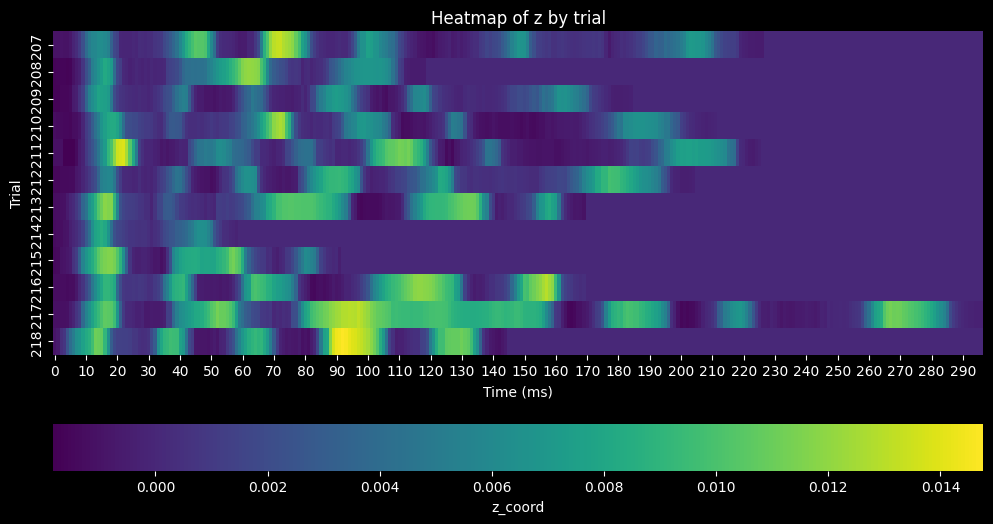

In [204]:
plotHeat(D.Dat, plot_trials = trange)

In [210]:
ht_dat[210].keys()

dict_keys(['strokes_cam', 'gaps_cam', 'pts_time_cam_all', 'strokes_touch', 'strokes_task', 'pnut_strokes', 'strokes_raw_times', 'likelihood_min', 'reg_strokes_cam', 'reg_gaps_cam', 'reg_pts_time_cam_all', 'trans_strokes_cam', 'trans_gaps_cam', 'trans_pts_time_cam_all', 'onset_offset_times', 'strokes_cam_calc_onoff', 'gaps_cam_calc_onoff', 'skipped', 'trans_pts_time_cam_all_int', 'coefs_used'])

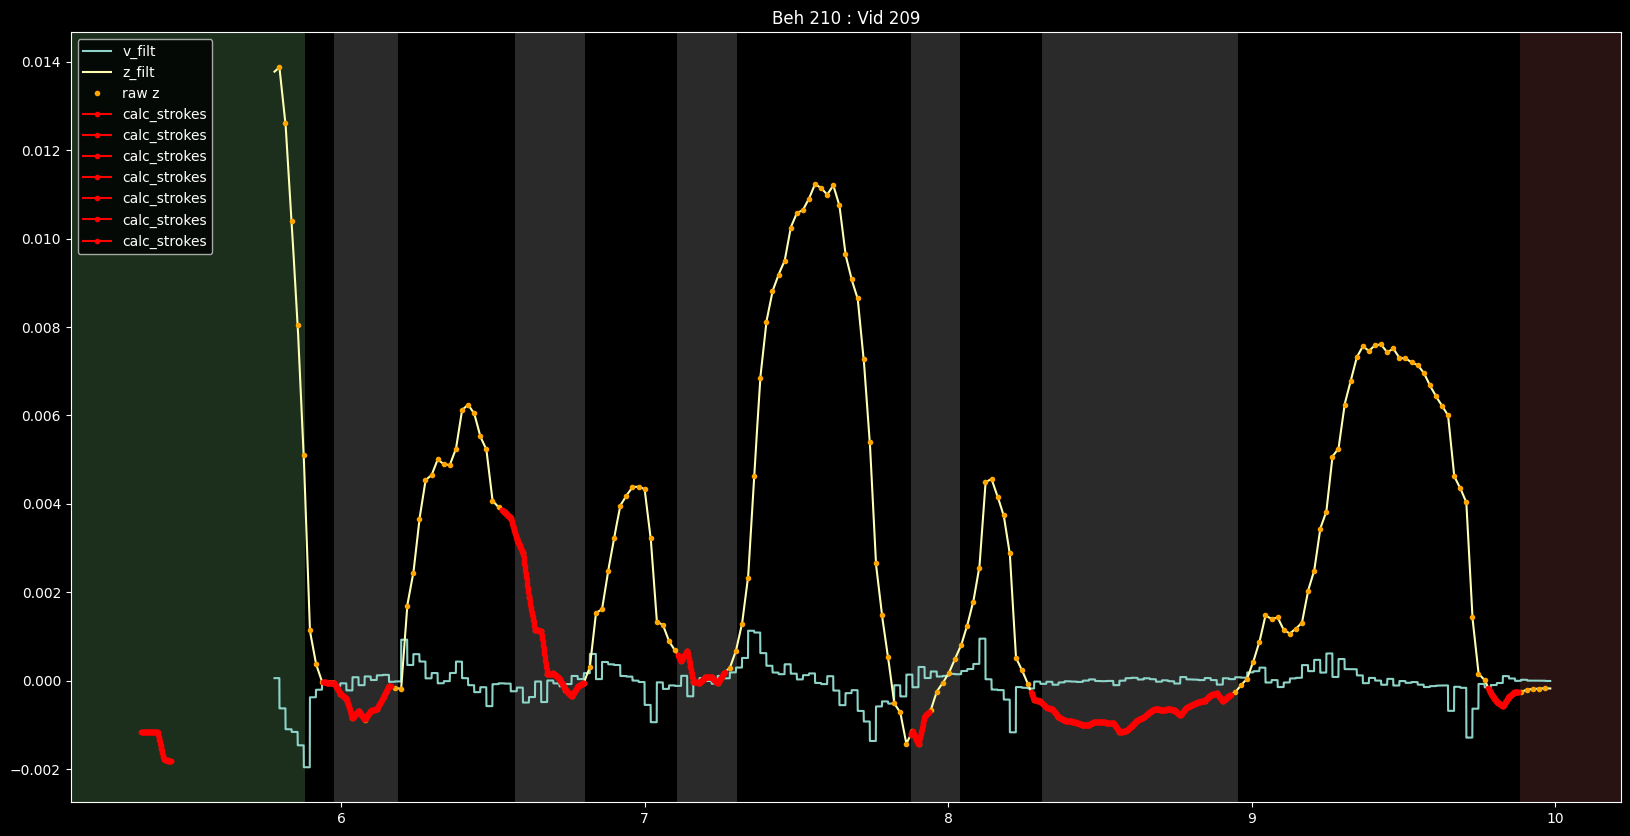

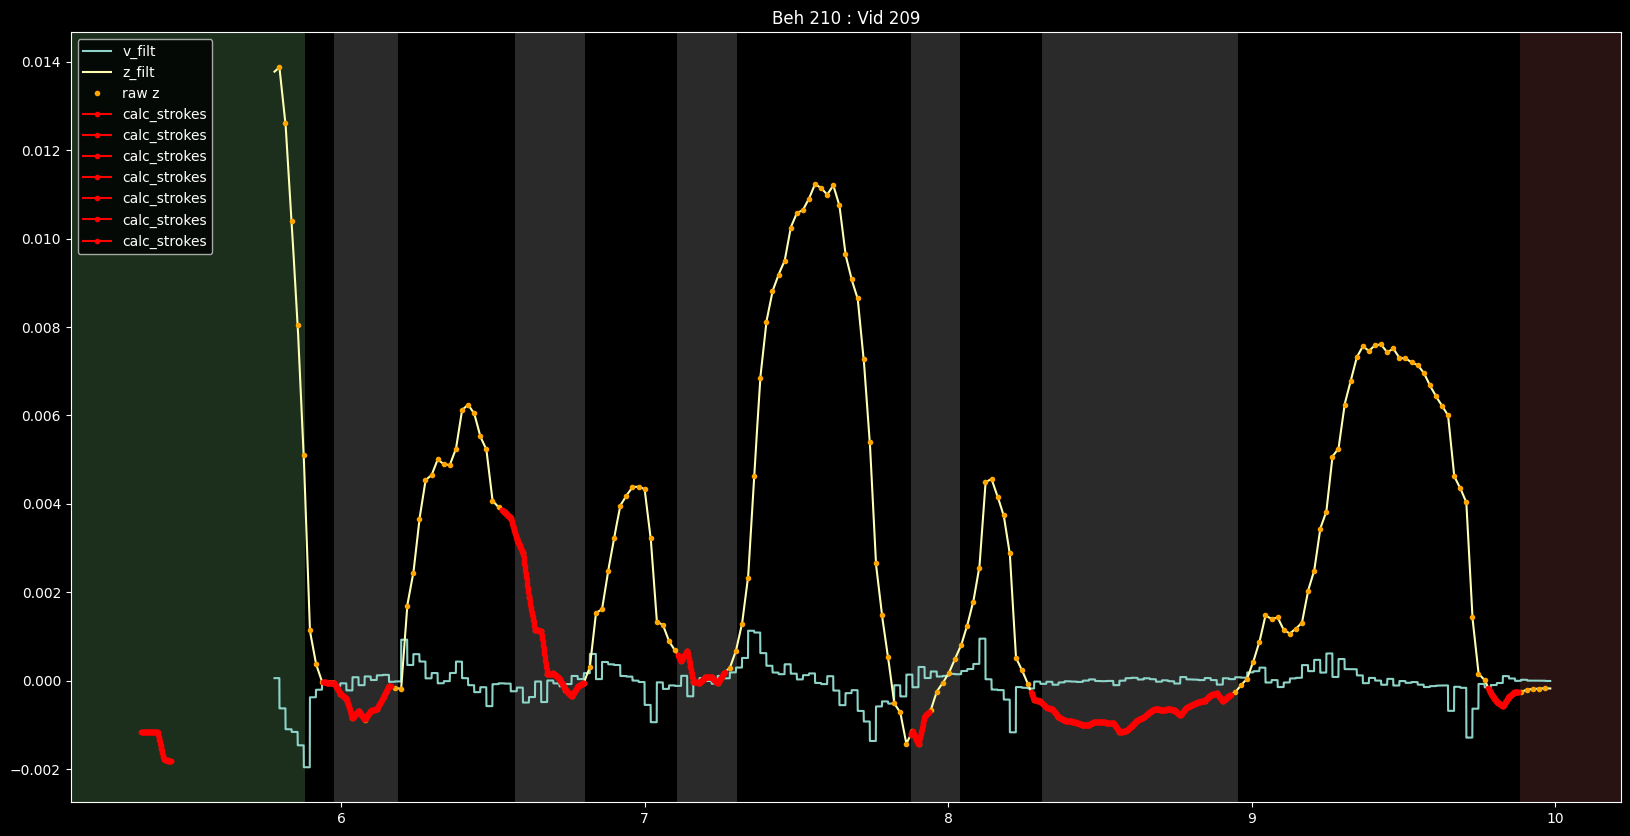

In [249]:
plotTrialsTrajectories(fd,ht_dat,trial_ml2=210)

In [49]:
D.grammarparses_successbinary_score_wrapper()  

*** RUNNING D.preprocessGood using these params:
['remove_baseline']
-- Len of D, before applying this param: remove_baseline, ... 755
after: 755
Defined new column: epochset
.. Appended new column 'char_seq', version: task_matlab
Defined new column: epochset
... merge_sets_with_only_single_epoch... 
('llCV3',) only has one epoch!:  ['llCV3']
Mergin these epochset's .. 
[('llCV3',)]
Into this new epochset: ('LEFTOVER',)
.. Appended new column 'char_seq', version: task_matlab
Defined new column: epochset
... merge_sets_with_only_single_epoch... 
('llCV3',) only has one epoch!:  ['llCV3']
Mergin these epochset's .. 
[('llCV3',)]
Into this new epochset: ('LEFTOVER',)
Assinging to column: self.Dat[taskfeat_cat]
*** RUNNING D.preprocessGood using these params:
['remove_baseline']
-- Len of D, before applying this param: remove_baseline, ... 755
after: 755
trial # 0
trial # 100
trial # 200
trial # 300
trial # 400
trial # 500
trial # 600
trial # 700
n samples for conjunctions of score_name, a

In [ ]:
#Fun little bonus columns
D.trialcode_tuple_extract_assign()
D.grammarparses_chunk_transitions_gaps_extract_batch()

In [ ]:
import os

def find_function_in_file(file_path, search_term):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            if search_term in line:
                print(f"Line {i+1}: {line.strip()}")

# Path to the dataset.py file
file_path = os.path.join(pythonlib.__path__[0], 'dataset', 'dataset.py')

# Search for the term 'chunk_rank'
find_function_in_file(file_path, 'chunk_rank')

Line 9361: if "chunk_rank" in tokens[0].keys():
Line 9363: print("chunk_rank:", [(t["chunk_rank"]) for t in tokens])
Line 9469: print("CHUNK RANK: ", [t["chunk_rank"] for t in tok])
Line 9579: #         chunk_seq = [(tok["chunk_rank"], tok["chunk_within_rank"]) for tok in Tk.Tokens]
Line 9585: #         if tok["chunk_rank"]==cr_prev:
Line 9589: #         elif tok["chunk_rank"]==cr_prev+1:
Line 9592: #         elif tok["chunk_rank"]>cr_prev:
Line 9600: #         cr_prev = tok["chunk_rank"]
Line 9647: for feat in ["chunk_rank", "chunk_within_rank", "shape"]:
Line 9688: dfgaps = append_col_with_grp_index(dfgaps, ["epoch", "syntax_concrete", "gap_chunk_rank"], "ep_sy_gcr")
Line 9693: dfgaps["gap_chunk_rank_str"] = ["".join([str(xx) for xx in x]) for x in dfgaps["gap_chunk_rank"]]
Line 9719: fig = sns.catplot(data=dfgaps, x="gap_chunk_rank_str", y="gap_dur", hue="gap_dur_bin", col="epoch",
Line 9723: fig = sns.catplot(data=dfgaps, x="gap_chunk_rank_str", y="gap_dur", hue="gap_dur_bin", col=